In this project, I decided to work on semantic segmantation of blood vessels images.

The data that I've used comes from DRIVE dataset. It is a small dataset of 40 images. I collected the data from https://drive.grand-challenge.org/ website. The data consists of binary segmentation masks for half of the images, to make it possible to validate the model. For this project, I am using only this half first, to make sure my idea for solving the task works as expected, and then, I will perform the inference on the other half to check if my soltion works. The task is quite challenging, due to limited amount of labelled training data. I've been using Google Collab notebook to make it possible to use free GPU, that makes training process much faster.

# Dataset setting

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import zipfile
from tqdm.auto import tqdm

def copy_with_progress(src, dst):
    """파일 복사 진행률 표시"""
    size = os.path.getsize(src)
    with open(src, 'rb') as fsrc:
        with open(dst, 'wb') as fdst:
            with tqdm(total=size, unit='B', unit_scale=True, desc=f"🚚 {os.path.basename(src)} 복사 중") as pbar:
                while True:
                    buf = fsrc.read(1024*1024) # 1MB 단위 복사
                    if not buf:
                        break
                    fdst.write(buf)
                    pbar.update(len(buf))

def unzip_with_progress(zip_path, extract_path):
    """압축 해제 진행률 표시"""
    with zipfile.ZipFile(zip_path, 'r') as zf:
        files = zf.namelist()
        for file in tqdm(files, desc=f"🚀 {os.path.basename(zip_path)} 해제 중", unit="file"):
            zf.extract(file, extract_path)

# --- 실행 부분 ---

# 1. 꼬인 폴더가 있다면 미리 정리
!rm -rf /content/split_dataset

# 2. 드라이브에서 로컬(/content)로 복사 (진행 바 표시)
copy_with_progress("/content/drive/MyDrive/battery_project/backup/train_dataset.zip", "/content/train_dataset.zip")
copy_with_progress("/content/drive/MyDrive/battery_project/backup/val_dataset.zip", "/content/val_dataset.zip")

# 3. 로컬 SSD에서 압축 해제 (진행 바 표시 / 중첩 방지를 위해 '/'에 해제)
unzip_with_progress("/content/train_dataset.zip", "/")
unzip_with_progress("/content/val_dataset.zip", "/")

# 4. 사용 완료한 로컬 zip 파일 삭제 (용량 확보)
os.remove("/content/train_dataset.zip")
os.remove("/content/val_dataset.zip")

print("\n✨ 모든 작업이 완료되었습니다! /content/split_dataset 구조를 확인하세요.")

🚚 train_dataset.zip 복사 중:   0%|          | 0.00/31.3G [00:00<?, ?B/s]

🚚 val_dataset.zip 복사 중:   0%|          | 0.00/7.84G [00:00<?, ?B/s]

🚀 train_dataset.zip 해제 중:   0%|          | 0/35597 [00:00<?, ?file/s]

🚀 val_dataset.zip 해제 중:   0%|          | 0/8903 [00:00<?, ?file/s]


✨ 모든 작업이 완료되었습니다! /content/split_dataset 구조를 확인하세요.


In [11]:
# PyTorch
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.utils import make_grid

# Data manipulations
import numpy as np
from PIL import Image
import cv2
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt

# helpers
import glob
import os
import copy
import time
import csv
from google.colab import drive

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

data_dir = '/content/split_dataset'

After preparing the data, one need to implement class representing the dataset and corresponding dataloaders. It is a convention of PyTorch, deep learning framework that I'm using.

In [12]:
import sys
import os

# 1. 내 드라이브로 복사한 폴더의 경로 (방금 복사한 경로로 수정하세요)
my_personal_path = '/content/drive/MyDrive/attention_unet_ys'

# 2. 기존 공유 폴더 경로가 sys.path에 있다면 모두 제거 (에러 방지)
sys.path = [p for p in sys.path if '.shortcut-targets-by-id' not in p]

# 3. 내 드라이브 경로를 최우선 순위로 추가
if my_personal_path not in sys.path:
    sys.path.insert(0, my_personal_path)

print(f"✅ 이제 이 경로를 먼저 검색합니다: {sys.path[0]}")

✅ 이제 이 경로를 먼저 검색합니다: /content/drive/MyDrive/attention_unet_ys


In [13]:
import importlib
import dataset
import torch

# 1. 수정된 파일을 강제로 다시 읽어오기
importlib.reload(dataset)
from dataset import SegmentationDataset

print("✅ dataset.py의 수정 사항이 성공적으로 반영되었습니다!")

ModuleNotFoundError: No module named 'dataset'

In [9]:
import dataset
print(f"📍 현재 로드된 파일 위치: {dataset.__file__}")

ModuleNotFoundError: No module named 'dataset'

In [ ]:
try:
    # 실제 데이터셋 경로로 설정
    train_ds = SegmentationDataset(subset_path='/content/split_dataset/train', transform=None)
    sample = train_ds[0]

    unique_vals = torch.unique(sample['mask'])
    print(f"📊 마스크 유니크 값: {unique_vals.tolist()}")
    print(f"📦 이미지 텐서 크기: {sample['image'].shape}") # [3, H, W] 형태여야 함

    if len(unique_vals) > 1:
        print("🚀 모든 준비가 끝났습니다. 이제 학습을 시작하세요!")
except Exception as e:
    print(f"❌ 여전히 에러가 발생합니다: {e}")

❌ 여전히 에러가 발생합니다: SegmentationDataset.__init__() got an unexpected keyword argument 'subset_path'


In [ ]:
try:
    # 🚀 인자 이름을 클래스 정의와 똑같이 맞춰줍니다.
    train_ds = SegmentationDataset(
        root_dir='/content/split_dataset',   # 최상위 경로
        image_folder='train/images',        # 이미지 폴더 상대 경로
        mask_folder='train/masks',          # 마스크 폴더 상대 경로
        subset='training',                  # 출력용 이름
        transform=None,                     # 변환 함수 (없으면 None)
        bg_keep_ratio=0.1                   # 배경 유지 비율
    )

    # 첫 번째 샘플 가져오기
    sample = train_ds[0]

    unique_vals = torch.unique(sample['mask'])
    print(f"📊 마스크 유니크 값: {unique_vals.tolist()}")
    print(f"📦 이미지 텐서 크기: {sample['image'].shape}")

    if len(unique_vals) > 0: # 0(배경)만 있어도 일단 로드는 성공한 것
        print("✅ 데이터 로드 성공!")
        if any(v in unique_vals.tolist() for v in [2, 3]):
            print("🚀 결함 데이터(2 or 3)가 포함된 조각입니다. 학습 준비 완료!")
        else:
            print("💡 배경/본체만 있는 조각입니다. 전수 조사를 통해 결함을 확인하세요.")

except Exception as e:
    print(f"❌ 여전히 에러가 발생합니다: {e}")

❌ 여전히 에러가 발생합니다: [Errno 2] No such file or directory: '/content/split_dataset/train/images'


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
import cv2
import json
import numpy as np
import os
import torch

class SegmentationDataset(Dataset):
    """Segmentation Dataset"""

    def __init__(self,
                 root_dir,
                 image_folder,
                 mask_folder,
                 transform=None,
                 image_colormode='rgb',
                 mask_colormode='grayscale',
                 seed=42,
                 fraction=0.7,
                 subset=None):
        """
        Args:
            image_folder (string) = 'Images' : Name of the folder which contains the Images.
            mask_folder (string)  = 'Masks : Name of the folder which contains the Masks.
            transform (callable, optional): Optional transform to be applied on a sample.
            seed: Specify a seed for the train and test split
            fraction: A float value from 0 to 1 which specifies the validation split fraction
            subset: 'Train' or 'Test' to select the appropriate set.
            image_colormode: 'rgb' or 'grayscale'
            mask_colormode: 'rgb' or 'grayscale'
        """
        self.color_dict = {'rgb': 1, 'grayscale': 0}
        assert (image_colormode in ['rgb', 'grayscale'])
        assert (mask_colormode in ['rgb', 'grayscale'])

        self.imagecolorflag = self.color_dict[image_colormode]
        self.maskcolorflag = self.color_dict[mask_colormode]
        self.root_dir = root_dir
        self.transform = transform

        if not fraction:
            self.image_names = sorted(
                glob.glob(os.path.join(self.root_dir, image_folder, '*')))
            self.mask_names = sorted(
                glob.glob(os.path.join(self.root_dir, mask_folder, '*')))
        else:
            assert (subset in ['training', 'test'])
            self.fraction = fraction
            self.image_list = np.array(
                sorted(glob.glob(os.path.join(self.root_dir, image_folder, '*'))))
            self.mask_list = np.array(
                sorted(glob.glob(os.path.join(self.root_dir, mask_folder, '*'))))
            if seed:
                np.random.seed(seed)
                indices = np.arange(len(self.image_list))
                np.random.shuffle(indices)
                self.image_list = self.image_list[indices]
                self.mask_list = self.mask_list[indices]
            if subset == 'training':
                self.image_names = self.image_list[:int(
                    np.ceil(len(self.image_list) * (1 - self.fraction)))]
                self.mask_names = self.mask_list[:int(
                    np.ceil(len(self.mask_list) * (1 - self.fraction)))]
            else:
                self.image_names = self.image_list[int(
                    np.ceil(len(self.image_list) * (1 - self.fraction))):]
                self.mask_names = self.mask_list[int(
                    np.ceil(len(self.mask_list) * (1 - self.fraction))):]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_path, img_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]

        json_file = os.path.splitext(img_name)[0] + '.json'
        json_full_path = os.path.join(self.json_path, json_file)

        # --- 디버깅용 프린트 추가 ---
        if idx == 0: # 첫 번째 데이터에 대해서만 출력
            print(f"🔍 이미지 경로: {img_path}")
            print(f"🔍 JSON 예상 경로: {json_full_path}")
            print(f"🔍 JSON 파일 존재 여부: {os.path.exists(json_full_path)}")
        # -------------------------

        if os.path.exists(json_full_path):
            try:
                with open(json_full_path, 'r') as f:
                    data = json.load(f)
                    # JSON 키가 실제로 무엇인지 확인
                    if idx == 0:
                        print(f"🔍 JSON 실제 키(Keys): {data.keys()}")
                    mask = self.generate_multiclass_mask(data, w, h)
            except Exception as e:
                if idx == 0: print(f"❌ JSON 파싱 에러: {e}")
                mask = np.zeros((h, w), dtype=np.uint8)
        else:
            mask = np.zeros((h, w), dtype=np.uint8)

        # Albumentations Transform 적용
        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

            if not isinstance(mask, torch.Tensor):
                mask = torch.from_numpy(mask).long()
            else:
                mask = mask.long()
        else:
            image = torch.from_numpy(image.transpose(2,0,1)).float() / 255.0
            mask = torch.from_numpy(mask).long()

        return {'image': image, 'mask': mask}

print("✅ 최신 JSON 버전 SegmentationDataset 클래스 정의 완료!")


✅ 최신 JSON 버전 SegmentationDataset 클래스 정의 완료!


One thing that is worth noticing, is that I had to add some black padding around images. It is because, I am using U-Net - like architecture with learnable visual attention blocks, and spatial dimensions of signal coming from skip connections and their corresponging feature maps must fit together. That is why the pictures after padding have size (592, 576) - they can be downsampled using max pooling 4 times (the dimensions are possible to divide by 4).

The picture that helps to understand the U-Net architecture is given below. It is a encoder-decoder architecture, that means that input image is first downsampled using max pooling. This process produces feature maps, that is semantic features coming from imput image. Then, the feature maps are upsampled again, to classify each pixel in the image. To make this process more accurate, authors of the architecture decided to use skip connections: signal from feature maps is combined with input image. It helps to decide precisely, which picture should be considered positive class (in this case: blood vessel) and which one should be marked as a background.

The picture's source is the U-Net paper.

![alt text](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

Recently, the field of Deep Learning is evolving extremely fast. New ideas and architectures are proposed frequently. One of them, that helped to improve NLP is attention. It is an idea that we can try to make our model focus on certain parts of the incoming signal (in case of text: sequences of words, in case of images: matrices with their digital representation). Computer Vision community, inspired by the work of their colleagues, have developed an idea of visual attention. For example the paper "Learn to pay attention" by Jetley et al describes the usage of learnable attention gate, that is additional blocks that gather signals from different layers of the network and learn where useful information from the image is. The prediction is made by concatenating the output from the attention blocks, and not by making use of the last layer of the network directly. The image from the article that describes the idea is given below: ![alt text](https://miro.medium.com/max/616/0*8r63L3yR66SVBgJR)

This idea was futher developed for semantic segmentation tasks by Oktay et al in the article "Attention U-Net: Learning Where to Look for the Pancreas". The difference is that attention blocks are now learning to filter signal from skip connections by estimating the information coming from them by comparing it with features from feature maps.
![alt text](https://miro.medium.com/max/780/1*PdYEf-OuUWkRsm2Lfrmy6A.png)


I decided to use this idea for my dataset, because it might work quite well, and also I would learn a lot.

In [ ]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        # number of input channels is a number of filters in the previous layer
        # number of output channels is a number of filters in the current layer
        # "same" convolutions
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class UpConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class AttentionBlock(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l, n_coefficients):
        """
        :param F_g: number of feature maps (channels) in previous layer
        :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
        :param n_coefficients: number of learnable multi-dimensional attention coefficients
        """
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection):
        """
        :param gate: gating signal from previous layer
        :param skip_connection: activation from corresponding encoder layer
        :return: output activations
        """
        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out


class AttentionUNet(nn.Module):

    def __init__(self, img_ch=3, output_ch=1):
        super(AttentionUNet, self).__init__()

        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = ConvBlock(img_ch, 64)
        self.Conv2 = ConvBlock(64, 128)
        self.Conv3 = ConvBlock(128, 256)
        self.Conv4 = ConvBlock(256, 512)
        self.Conv5 = ConvBlock(512, 1024)

        self.Up5 = UpConv(1024, 512)
        self.Att5 = AttentionBlock(F_g=512, F_l=512, n_coefficients=256)
        self.UpConv5 = ConvBlock(1024, 512)

        self.Up4 = UpConv(512, 256)
        self.Att4 = AttentionBlock(F_g=256, F_l=256, n_coefficients=128)
        self.UpConv4 = ConvBlock(512, 256)

        self.Up3 = UpConv(256, 128)
        self.Att3 = AttentionBlock(F_g=128, F_l=128, n_coefficients=64)
        self.UpConv3 = ConvBlock(256, 128)

        self.Up2 = UpConv(128, 64)
        self.Att2 = AttentionBlock(F_g=64, F_l=64, n_coefficients=32)
        self.UpConv2 = ConvBlock(128, 64)

        self.Conv = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        """
        e : encoder layers
        d : decoder layers
        s : skip-connections from encoder layers to decoder layers
        """
        e1 = self.Conv1(x)

        e2 = self.MaxPool(e1)
        e2 = self.Conv2(e2)

        e3 = self.MaxPool(e2)
        e3 = self.Conv3(e3)

        e4 = self.MaxPool(e3)
        e4 = self.Conv4(e4)

        e5 = self.MaxPool(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        s4 = self.Att5(gate=d5, skip_connection=e4)
        d5 = torch.cat((s4, d5), dim=1) # concatenate attention-weighted skip connection with previous layer output
        d5 = self.UpConv5(d5)

        d4 = self.Up4(d5)
        s3 = self.Att4(gate=d4, skip_connection=e3)
        d4 = torch.cat((s3, d4), dim=1)
        d4 = self.UpConv4(d4)

        d3 = self.Up3(d4)
        s2 = self.Att3(gate=d3, skip_connection=e2)
        d3 = torch.cat((s2, d3), dim=1)
        d3 = self.UpConv3(d3)

        d2 = self.Up2(d3)
        s1 = self.Att2(gate=d2, skip_connection=e1)
        d2 = torch.cat((s1, d2), dim=1)
        d2 = self.UpConv2(d2)

        out = self.Conv(d2)

        return out


I have prepared several transformations to be applied on the images. I've used random flip as augmentation technique. I am also using CLAHE (Contrast Limiting Adaptive Histogram Equalization) nad Bilateral filter to improve the quality of images: CLAHE preforms histogram equalization in a smart way. I included Bilateral filter because I've noticed that after CLAHE the pictures are a little bit noisy. I decided to use bilateral filter instead of median filter because it keeps the edges sharp, what is crucial in segmentation task.

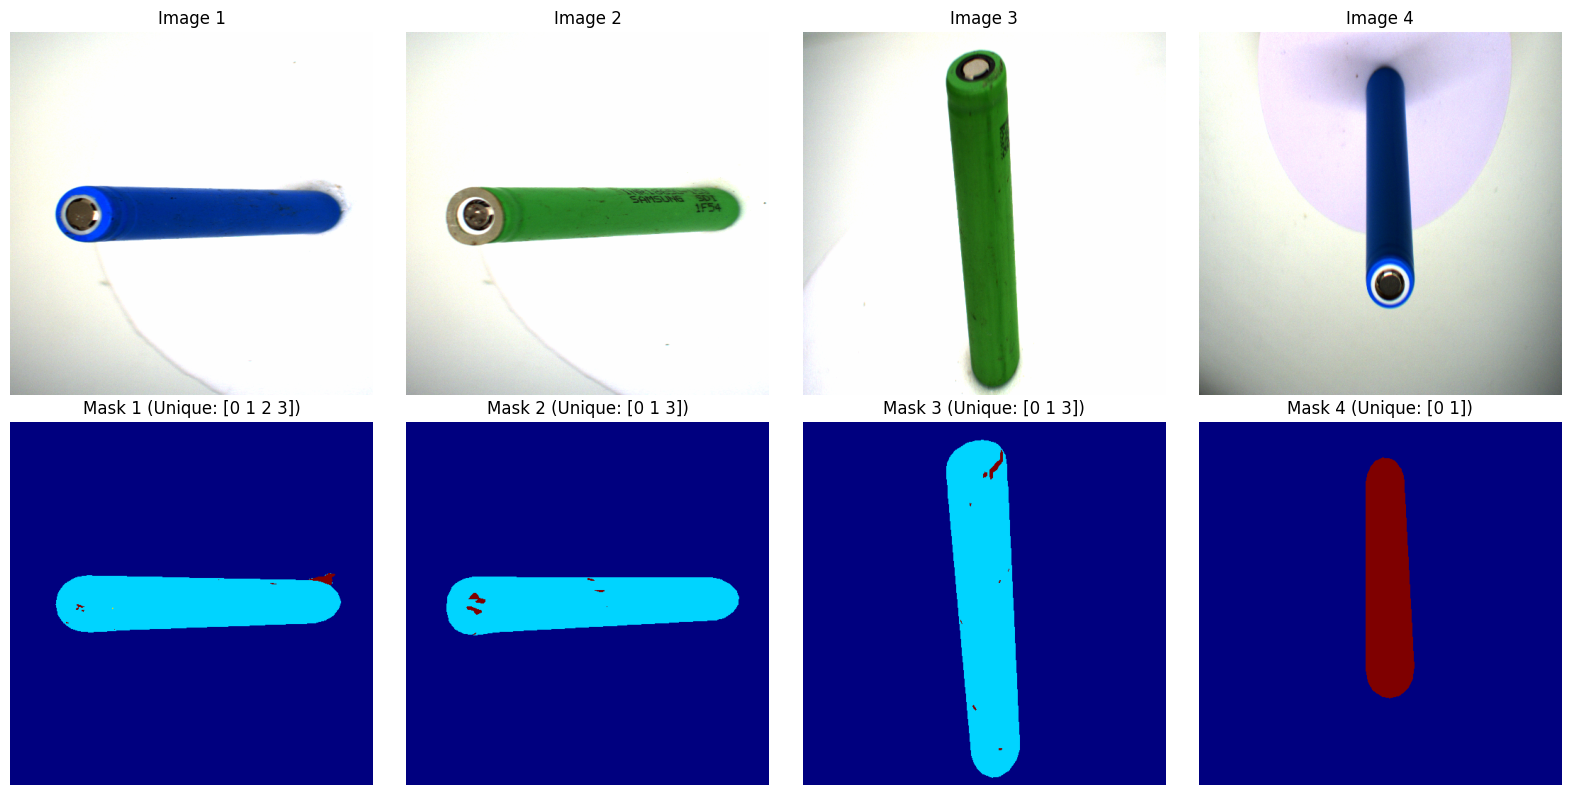

In [ ]:
class Resize(object):
    """Resize image and/or masks."""

    def __init__(self, image_resize, mask_resize):
        self.image_resize = image_resize
        self.mask_resize = mask_resize

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        if len(image.shape) == 3:
            image = image.transpose(1, 2, 0)
        if len(mask.shape) == 3:
            mask = mask.transpose(1, 2, 0)
        mask = cv2.resize(mask, self.mask_resize, cv2.INTER_AREA)
        image = cv2.resize(image, self.image_resize, cv2.INTER_AREA)
        if len(image.shape) == 3:
            image = image.transpose(2, 0, 1)
        if len(mask.shape) == 3:
            mask = mask.transpose(2, 0, 1)

        return {'image': image,
                'mask': mask}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample, mask_resize=None, image_resize=None):
        image, mask = sample['image'], sample['mask']
        image = image.transpose(2, 0, 1)

        if len(mask.shape) == 2:
            mask = mask.reshape((1,) + mask.shape)
        if len(image.shape) == 2:
            image = image.reshape((1,) + image.shape)
        return {'image': torch.from_numpy(image),
                'mask': torch.from_numpy(mask)}


class Normalize(object):
    """Normalize image"""

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        return {'image': image.type(torch.FloatTensor) / 255,
                'mask': mask.type(torch.FloatTensor) / 255}


class HorizontalFlip(object):
    def __init__(self, prob=.5):
        self.prob = prob

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        if np.random.random() < self.prob:
            image = cv2.flip(image, 1)
            mask = cv2.flip(mask, 1)

        return {'image': image,
                'mask': mask}


class ApplyClaheColor(object):

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        clahe = cv2.createCLAHE(clipLimit=2.0)
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

        return {'image': img_output,
                'mask': mask}


class ApplyClahe(object):

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        clahe = cv2.createCLAHE(clipLimit=2.0)
        image = clahe.apply(image)

        return {'image': image,
                'mask': mask}


class Color2Gray(object):

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return {'image': image,
                'mask': mask}


class Denoise(object):

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        image = cv2.bilateralFilter(image, d=5, sigmaColor=9, sigmaSpace=9)
        return {'image': image,
                'mask': mask}


def get_data_loaders(data_dir, image_folder='training/images', mask_folder='training/1st_manual', batch_size=8):
    data_transforms = {
        # Resize((592, 576), (592, 576)),
        'training': transforms.Compose([HorizontalFlip(), ApplyClaheColor(), Denoise(), ToTensor(), Normalize()]),
        'test': transforms.Compose([HorizontalFlip(), ApplyClaheColor(), Denoise(), ToTensor(), Normalize()]),
    }

    image_datasets = {x: SegmentationDataset(root_dir=data_dir,
                                             transform=data_transforms[x],
                                             image_folder=image_folder,
                                             mask_folder=mask_folder,
                                             subset=x)
                      for x in ['training', 'test']}

    data_loaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0)
                    for x in ['training', 'test']}

    return data_loaders

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

def plot_batch_from_dataloader(dataloaders, batch_size=4):
    # 'training' 대신 실제 존재하는 키인 'train'을 사용합니다.
    batch = next(iter(dataloaders['train']))

    images = batch['image']
    masks = batch['mask']

    plt.figure(figsize=(batch_size * 4, 8))

    for i in range(min(batch_size, len(images))):
        # 이미지 시각화 (Normalize 복원)
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        # 마스크 시각화 (0, 1, 2, 3 클래스)
        mask = masks[i].cpu().numpy()

        plt.subplot(2, batch_size, i + 1)
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis('off')

        plt.subplot(2, batch_size, i + 1 + batch_size)
        plt.imshow(mask, cmap='jet', vmin=0, vmax=3) # 클래스 별 다른 색깔 시각화
        plt.title(f"Mask {i+1} (Unique: {np.unique(mask)})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def myimshow(img, unnormalize=False):
    """

    :param img: tensor of images, first dimension is number of images in the batch
    :param unnormalize: whenever to unnormalize the image before plotting
    :return: void
    """
    if unnormalize:
        img = img * 255

    np_img = img.numpy()
    plt.imshow(np.transpose(np_img[0], (1, 2, 0)))
    plt.show()


def images_generator(path):
    for img_name in glob.glob(os.path.join(path, '*')):
        image = np.array(Image.open(img_name)).transpose(2, 0, 1)
        yield image

For segmenation task, Dice Coefficient is often used to measure performance of the models. I havn't used it as a loss function directly, because I read that training the model with such loss function is not always stable. I decided to use Focal loss, because it has this nice property that it focuses on imbalanced positive class. It was developed for object detection, but it can be used for segmenation too. In the dataset that I am using there is quite a big class imbalance - most of the pixels don't represent blood vessels.

The picture below help us understand Dice Coefficient intuitevely. It is a 2 * |AnB| / (|A| + |B|)

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1f/Intersection_of_sets_A_and_B.svg/1200px-Intersection_of_sets_A_and_B.svg.png)

The plot helped me understand the Focal Loss. It comes from the Focal Loss paper.
![alt text](https://miro.medium.com/max/1032/1*wLf0KMIzBsXPcxsN7yBrIA.png)

In [ ]:
import torch

def dice_coeff(prediction, target, num_classes=4):
    dice = 0
    # 배경(0)을 제외한 1, 2, 3번 클래스에 대해서만 Dice 계산
    for cl in range(1, num_classes):
        p = (prediction == cl).float()
        t = (target == cl).float()
        intersection = (p * t).sum()
        union = p.sum() + t.sum()
        dice += (2. * intersection + 1e-6) / (union + 1e-6)

    return dice / (num_classes - 1)


import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiClassHybridLoss(nn.Module):
    def __init__(self, weights=[1.0, 5.0, 60.0, 30.0], dice_weight=0.5):
        super(MultiClassHybridLoss, self).__init__()
        self.register_buffer('weights', torch.tensor(weights))
        self.dice_weight = dice_weight

    def forward(self, inputs, targets):
        # 1. 가중치 적용 CrossEntropy (Focal 효과 포함)
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weights)

        # 2. 다중 클래스 Dice Loss
        inputs_soft = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=4).permute(0, 3, 1, 2).float()

        intersection = torch.sum(inputs_soft * targets_one_hot, dim=(0, 2, 3))
        total = torch.sum(inputs_soft + targets_one_hot, dim=(0, 2, 3))
        dice_loss = 1 - torch.mean((2. * intersection + 1e-6) / (total + 1e-6))

        # 3. Hybrid 결합
        return (1 - self.dice_weight) * ce_loss + self.dice_weight * dice_loss

There is quite some code needed to got everything working. In the training loop I'am tracking loss in each batch for each epoch, and save it for plotting the learning curve.

Let's take a look at the images and their correspodning masks

In [ ]:
# train 폴더 안에 무슨 폴더들이 있는지 확인하는 명령어
!ls -F /content/split_dataset/train/

images/  labels/  masks/


In [ ]:
# 파일에서 불러오기
try:
    from utils import get_data_loaders
    print("✅ utils.py에서 get_data_loaders를 성공적으로 가져왔습니다!")
except ImportError as e:
    print(f"❌ 가져오기 실패: {e}")

✅ utils.py에서 get_data_loaders를 성공적으로 가져왔습니다!


In [ ]:
import os  # ★ 이 줄을 추가하세요!
import importlib
import utils

# 1. 모듈 리로드
importlib.reload(utils)
from utils import get_data_loaders

# 2. 데이터셋 경로 설정 및 로더 생성
dataset_path = '/content/split_dataset'

try:
    dataloaders = get_data_loaders(data_dir=dataset_path, batch_size=8)
    print(f"✅ 데이터로더 생성 성공! 키 목록: {list(dataloaders.keys())}")
except Exception as e:
    print(f"❌ 에러 발생: {e}")

✅ 데이터로더 생성 성공! 키 목록: ['train', 'val']


In [ ]:
import os
import cv2
import numpy as np

# 1. 경로 설정 확인
img_dir = '/content/split_dataset/train/images'
mask_dir = '/content/split_dataset/train/masks'

# 2. 파일 목록 샘플 추출
img_list = sorted(os.listdir(img_dir))
mask_list = sorted(os.listdir(mask_dir))

print(f"📸 이미지 폴더 파일 개수: {len(img_list)}")
print(f"🎭 마스크 폴더 파일 개수: {len(mask_list)}")

if len(img_list) > 0 and len(mask_list) > 0:
    test_img = img_list[0]
    # 이미지 파일명에서 확장자 제거 후 .png 붙이기
    expected_mask = os.path.splitext(test_img)[0] + '.png'

    mask_full_path = os.path.join(mask_dir, expected_mask)

    print(f"\n🧪 테스트 매칭:")
    print(f" - 이미지 파일명: {test_img}")
    print(f" - 예상 마스크명: {expected_mask}")
    print(f" - 실제 마스크 존재 여부: {os.path.exists(mask_full_path)}")

    if os.path.exists(mask_full_path):
        raw_mask = cv2.imread(mask_full_path, cv2.IMREAD_GRAYSCALE)
        print(f" - 마스크 내부 실제 값: {np.unique(raw_mask)}")
    else:
        print(f"❌ 매칭 실패! 마스크 폴더의 실제 파일명 하나만 알려주세요: {mask_list[0]}")
else:
    print("❌ 폴더가 비어있습니다. 경로를 다시 확인하세요.")

📸 이미지 폴더 파일 개수: 17797
🎭 마스크 폴더 파일 개수: 17797

🧪 테스트 매칭:
 - 이미지 파일명: RGB_cell_cylindrical_0001_010.png
 - 예상 마스크명: RGB_cell_cylindrical_0001_010.png
 - 실제 마스크 존재 여부: True
 - 마스크 내부 실제 값: [0 1 2 3]


학습을 시작하기 전에 데이터가 제대로 준비되었는지 검사

In [ ]:
# 1. 데이터셋 경로를 명시적으로 전달합니다.
dataset_path = '/content/split_dataset'

# 2. data_dir 인자를 추가하여 함수를 호출합니다.
dataloaders = get_data_loaders(data_dir=dataset_path, batch_size=4)

print(f"✅ 데이터로더 생성 성공! 키 목록: {list(dataloaders.keys())}")

✅ 데이터로더 생성 성공! 키 목록: ['train', 'val']


In [ ]:
from utils import get_data_loaders

# 1. 'data_dir' 경로를 반드시 넣어주어야 합니다!
dataset_path = '/content/split_dataset'
dataloaders = get_data_loaders(data_dir=dataset_path, batch_size=8)

# 2. 아까 성공했을 때 키 목록이 ['train', 'val']이었으므로, 이름을 맞춰줍니다.
train_loader = dataloaders['train']
val_loader = dataloaders['val']

print("✅ 데이터로더가 새 Dataset 설정으로 다시 준비되었습니다.")
print(f"📦 Train 배치 개수: {len(train_loader)}")
print(f"📦 Val 배치 개수: {len(val_loader)}")

✅ 데이터로더가 새 Dataset 설정으로 다시 준비되었습니다.
📦 Train 배치 개수: 2225
📦 Val 배치 개수: 557


# Ground Truth 시각화

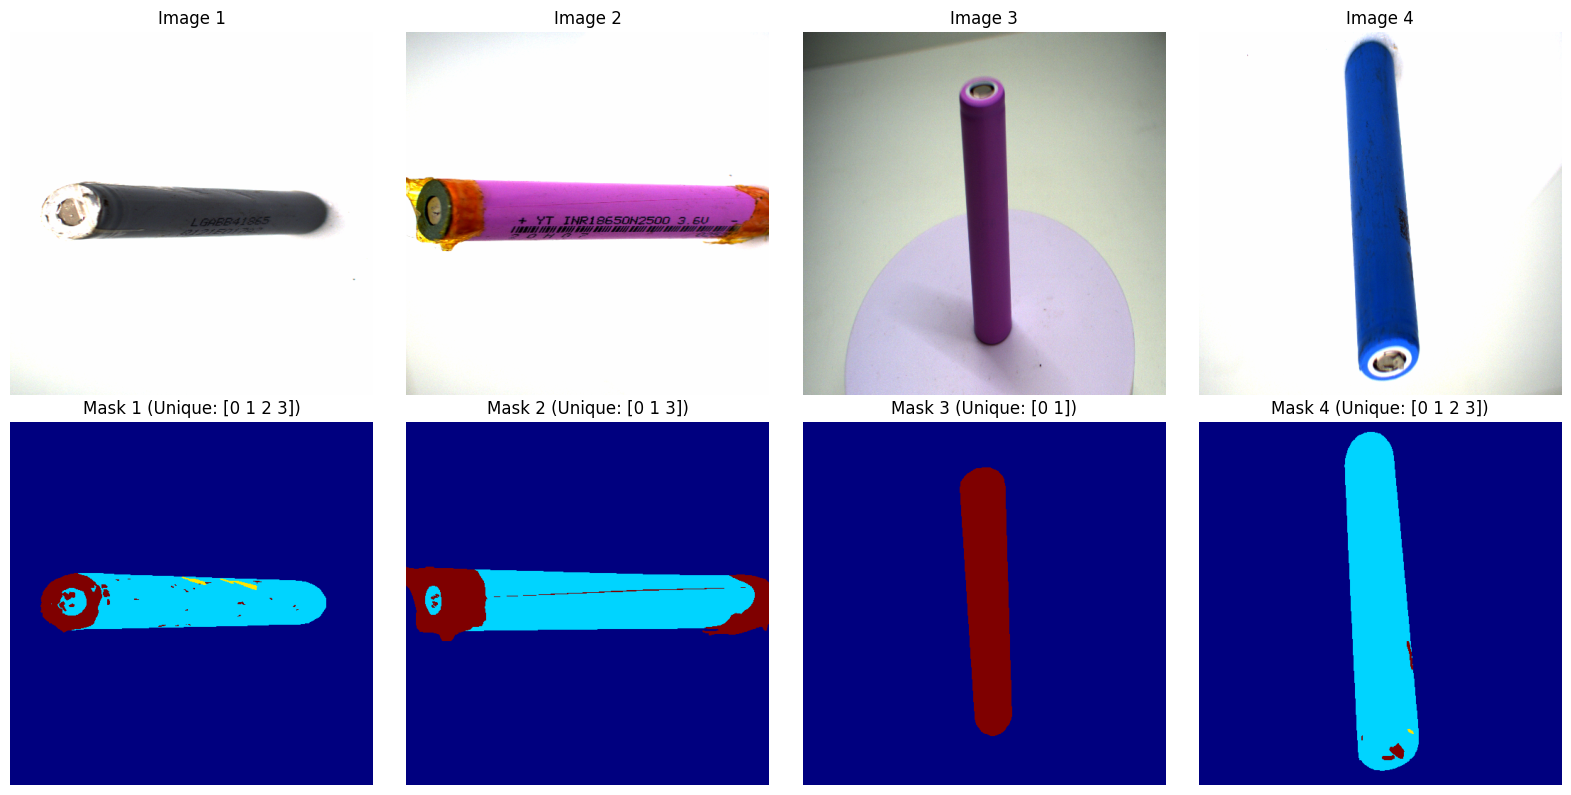

In [ ]:
plot_batch_from_dataloader(dataloaders, 4)

학습 함수 정의
- 혼합 정밀도(AMP)
- 가중치 적용 CrossEntropyLoss
- 학습 스케쥴러 ReduceLROnPlateau

In [ ]:
import torch
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm
import time
import copy

def train_and_test_with_wandb(model, dataloaders, optimizer, criterion, scheduler, num_epochs=30):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    scaler = GradScaler()
    class_names = ['BG', 'Body', 'Damaged', 'Pollution'] # 사용자님 설정 순서

    best_dice = 0.0

    for epoch in range(1, num_epochs + 1):
        epoch_log = {"epoch": epoch}
        print(f'\n🚀 Epoch {epoch}/{num_epochs} ' + '='*40)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            # 클래스별 Intersection과 Union을 누적하기 위한 변수
            total_inter = torch.zeros(len(class_names)).to(device)
            total_union = torch.zeros(len(class_names)).to(device)

            pbar = tqdm(dataloaders[phase], desc=f"[{phase}]", leave=False)
            for batch in pbar:
                inputs = batch['image'].to(device)
                masks = batch['mask'].to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    with autocast():
                        outputs = model(inputs)
                        loss = criterion(outputs, masks)

                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                preds = torch.argmax(outputs, dim=1)
                running_loss += loss.item() * inputs.size(0)

                # 클래스별 IoU 계산을 위한 누적
                for c in range(len(class_names)):
                    inter = ((preds == c) & (masks == c)).sum()
                    union = ((preds == c) | (masks == c)).sum()
                    total_inter[c] += inter
                    total_union[c] += union

                pbar.set_postfix(loss=f"{loss.item():.4f}")

            # 에폭 지표 계산 (Loss 및 mIoU)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            class_ious = (total_inter / (total_union + 1e-6)).cpu().numpy()
            miou = class_ious.mean()

            # WandB 로깅용 딕셔너리 구성
            epoch_log[f"{phase}/loss"] = epoch_loss
            epoch_log[f"{phase}/mIoU"] = miou

            # 🚀 클래스별 IoU 로깅 추가
            print(f"[{phase.upper()}] Loss: {epoch_loss:.4f} | mIoU: {miou:.4f}")
            iou_str = "   └─ "
            for i, name in enumerate(class_names):
                epoch_log[f"{phase}/IoU_{name}"] = class_ious[i]
                iou_str += f"{name}: {class_ious[i]:.4f} | "
            print(iou_str)

            if phase == 'val':
                scheduler.step(epoch_loss)
                epoch_log["lr"] = optimizer.param_groups[0]['lr']

                # mIoU 기준으로 베스트 모델 저장
                if miou > best_dice: # 변수명은 유지하되 miou 기준으로 체크
                    best_dice = miou
                    torch.save(model.state_dict(), "best_model.pth")
                    print(f"⭐ Best Model Saved! (mIoU: {miou:.4f})")

        # WandB 전송
        wandb.log(epoch_log)

    return model

# 학습 시작

After trying a few values of learning rate and number of epochs I've dicided to use following values:

In [ ]:
# 파일 안에 'class '로 시작하는 줄을 모두 출력합니다.
!grep "class " /content/drive/MyDrive/attention_unet/model.py
!grep "class " /content/drive/MyDrive/attention_unet/model_v3.py

class ConvBlock(nn.Module):
class UpConv(nn.Module):
class AttentionBlock(nn.Module):
class AttentionUNet(nn.Module):
class ConvBlock(nn.Module):
class UpConv(nn.Module):
class AttentionBlock(nn.Module):
class AttentionUNet_MobileNetV3(nn.Module):


In [ ]:
import torch
import torch.nn as nn

# 1. model_v3.py에서 정확한 클래스 이름으로 불러오기
try:
    from model_v3 import AttentionUNet_MobileNetV3
    print("✅ model_v3.py에서 AttentionUNet_MobileNetV3를 성공적으로 불러왔습니다.")
except ImportError as e:
    print(f"❌ 임포트 실패: {e}")
    # 혹시 모를 상황을 대비해 model.py의 AttentionUNet을 대안으로 설정
    from model import AttentionUNet as AttentionUNet_MobileNetV3
    print("⚠️ model_v3 대신 model.py의 AttentionUNet을 불러왔습니다.")

# 2. 모델 객체 생성 (L4 GPU 할당)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# output_ch=4: 배경(0), 오염(1), 파손(2), 본체(3)
# AttentionUNet_MobileNetV3는 보통 n_classes 대신 output_ch라는 인자명을 사용합니다.
model = AttentionUNet_MobileNetV3(output_ch=4).to(device)

print(f"🎸 모델 준비 완료! 현재 디바이스: {device}")

✅ model_v3.py에서 AttentionUNet_MobileNetV3를 성공적으로 불러왔습니다.
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 207MB/s]

🎸 모델 준비 완료! 현재 디바이스: cuda


In [ ]:
# 방법 A: 기본값(60.0 포함)을 그대로 쓸 때
criterion = MultiClassHybridLoss().to(device)

# 방법 B: 명시적으로 가중치를 넣어서 만들 때 (더 추천!)
my_weights = [1.0, 5.0, 60.0, 30.0]
criterion = MultiClassHybridLoss(weights=my_weights, dice_weight=0.5).to(device)

NameError: name 'MultiClassHybridLoss' is not defined

# 하이퍼 파라미터 점검

In [ ]:
import torch

def print_training_config_v4(model, optimizer, dataloaders, criterion, scheduler=None):
    print("="*60)
    print("🚀 [7트: 파손 집중 학습 최종 점검 리포트]")
    print("="*60)

    # 1. 데이터 세션 확인
    phase = 'train' if 'train' in dataloaders else list(dataloaders.keys())[0]
    train_loader = dataloaders[phase]
    batch = next(iter(train_loader))
    images, masks = batch['image'], batch['mask']
    b, c, h, w = images.shape

    # 2. 하드웨어 및 입력 정보
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🔹 Device: {device}")
    print(f"🔹 Input: {w}x{h} ({c} Channels) | Batch Size: {train_loader.batch_size}")
    # num_workers가 사라졌던 부분 복구
    print(f"🔹 DataLoader Workers: {train_loader.num_workers} (Parallel Loading)")

    # 3. 모델 및 옵티마이저
    total_params = sum(p.numel() for p in model.parameters())
    print(f"\n🔹 Model: {model.__class__.__name__} ({total_params:,} params)")
    print(f"🔹 Optimizer: {type(optimizer).__name__}")
    print(f"   - Current LR: {optimizer.param_groups[0]['lr']}")

    # 4. 스케줄러 정보 추가 (New!)
    if scheduler is not None:
        sched_name = type(scheduler).__name__
        print(f"🔹 Scheduler: {sched_name}")
        # 주요 스케줄러별 설정값 추출
        if 'ReduceLROnPlateau' in sched_name:
            print(f"   - Mode: {scheduler.mode} | Factor: {scheduler.factor} | Patience: {scheduler.patience}")
        elif hasattr(scheduler, 'step_size'):
            print(f"   - Step Size: {scheduler.step_size} | Gamma: {scheduler.gamma}")
    else:
        print("🔹 Scheduler: Not Used")

    # 5. 손실 함수 및 가중치 (Damaged 강화 확인)
    print(f"\n🔹 Criterion: {criterion.__class__.__name__}")
    class_names = ['Background', 'Body', 'Damaged', 'Pollution']

    weights = None
    if hasattr(criterion, 'weights'): weights = criterion.weights
    elif hasattr(criterion, 'weight'): weights = criterion.weight

    if weights is not None:
        w_np = weights.cpu().numpy()
        print(f"   📊 [Class Weights Mapping]")
        for i, name in enumerate(class_names):
            # 파손(Index 2)에 60.0이 들어갔는지 강조 표시
            focus = "🔥 [FOCUS]" if i == 2 else "      "
            print(f"    - Index {i} ({name:<10}): {w_np[i]:>5.1f} {focus}")

    print("="*60)

# 실행 (scheduler 인자를 꼭 넣어주세요!)
print_training_config_v4(model, optimizer, dataloaders, criterion, scheduler)

🚀 [7트: 파손 집중 학습 최종 점검 리포트]
🔹 Device: cuda
🔹 Input: 512x512 (3 Channels) | Batch Size: 8
🔹 DataLoader Workers: 2 (Parallel Loading)

🔹 Model: AttentionUNet_MobileNetV3 (3,451,360 params)
🔹 Optimizer: Adam
   - Current LR: 2.5e-05
🔹 Scheduler: ReduceLROnPlateau
   - Mode: min | Factor: 0.5 | Patience: 3

🔹 Criterion: MultiClassHybridLoss
   📊 [Class Weights Mapping]
    - Index 0 (Background):   1.0       
    - Index 1 (Body      ):   5.0       
    - Index 2 (Damaged   ):  60.0 🔥 [FOCUS]
    - Index 3 (Pollution ):  30.0       


학습 시작

0. L4 GPU
1. image size : 512*512
2. batch : 8
3. epoch : 30
4. num-class : 4
5. loss: FocalLoss -> CrossEntropyLoss (다중클래스)
6. 혼합 정밀도 학습 -> 연산 속도 향상
7. 가중치 변경 [1.0, 5.0, 60.0, 30.0]
8. 학습 스케줄러 추가 (ReduceLROnPlateau)
9. MobileNetv3 적용
10. Hybrid Loss: Dice + Focal
11. Albumentations 적용
12. Decoder 보강 (Deep Supervision)

In [ ]:
import wandb

# 1. 기존 세션이 있다면 확실히 종료
if wandb.run is not None:
    wandb.finish()

# 2. 강제 재로그인 (API 키를 다시 물어볼 수 있습니다)
# relogin=True를 쓰면 기존 인증 정보를 새로고침합니다.
wandb.login(relogin=True)

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# 프로젝트 이름과 실험 이름을 설정합니다.
wandb.init(
    project="battery-defect-segmentation",
    name="MobileNetV3-HybridLoss-DeepSupervision",
    config={
        "architecture": "MobileNetV3-Large",
        "encoder": "timm-mobilenetv3_large_100",
        "decoder_attention": "scse",
        "image_size": 512,
        "batch_size": 8,
        "epochs": 30,
        "learning_rate": 1e-4,
        "loss_function": "Hybrid(Dice+Focal)",
        "weights": [1.0, 5.0, 60.0, 30.0],
        "scheduler": "ReduceLROnPlateau",
        "augmentation": "Albumentations",
        "mixed_precision": True
    }
)

In [ ]:
# 학습 실행
model = train_and_test_with_wandb(
    model=model,
    dataloaders=dataloaders,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    num_epochs=30
)

# 학습 종료 후 wandb 마무리
wandb.finish()


🚀 Epoch 1/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1434 | mIoU: 0.7531
   └─ BG: 0.9971 | Body: 0.9569 | Damaged: 0.4336 | Pollution: 0.6249 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1980 | mIoU: 0.7657
   └─ BG: 0.9972 | Body: 0.9573 | Damaged: 0.4812 | Pollution: 0.6272 | 
⭐ Best Model Saved! (mIoU: 0.7657)

🚀 Epoch 2/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1417 | mIoU: 0.7570
   └─ BG: 0.9971 | Body: 0.9572 | Damaged: 0.4439 | Pollution: 0.6296 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1970 | mIoU: 0.7690
   └─ BG: 0.9976 | Body: 0.9606 | Damaged: 0.4971 | Pollution: 0.6206 | 
⭐ Best Model Saved! (mIoU: 0.7690)

🚀 Epoch 3/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1401 | mIoU: 0.7604
   └─ BG: 0.9971 | Body: 0.9571 | Damaged: 0.4554 | Pollution: 0.6318 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1953 | mIoU: 0.7709
   └─ BG: 0.9974 | Body: 0.9593 | Damaged: 0.4897 | Pollution: 0.6373 | 
⭐ Best Model Saved! (mIoU: 0.7709)

🚀 Epoch 4/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1391 | mIoU: 0.7648
   └─ BG: 0.9971 | Body: 0.9578 | Damaged: 0.4667 | Pollution: 0.6376 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1964 | mIoU: 0.7573
   └─ BG: 0.9971 | Body: 0.9570 | Damaged: 0.4462 | Pollution: 0.6291 | 

🚀 Epoch 5/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1388 | mIoU: 0.7654
   └─ BG: 0.9972 | Body: 0.9579 | Damaged: 0.4681 | Pollution: 0.6385 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1955 | mIoU: 0.7674
   └─ BG: 0.9977 | Body: 0.9613 | Damaged: 0.4857 | Pollution: 0.6247 | 

🚀 Epoch 6/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1376 | mIoU: 0.7679
   └─ BG: 0.9972 | Body: 0.9582 | Damaged: 0.4746 | Pollution: 0.6417 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1979 | mIoU: 0.7470
   └─ BG: 0.9975 | Body: 0.9591 | Damaged: 0.4018 | Pollution: 0.6299 | 

🚀 Epoch 7/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1368 | mIoU: 0.7695
   └─ BG: 0.9972 | Body: 0.9585 | Damaged: 0.4769 | Pollution: 0.6455 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1953 | mIoU: 0.7712
   └─ BG: 0.9974 | Body: 0.9587 | Damaged: 0.4878 | Pollution: 0.6406 | 
⭐ Best Model Saved! (mIoU: 0.7712)

🚀 Epoch 8/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1322 | mIoU: 0.7792
   └─ BG: 0.9973 | Body: 0.9597 | Damaged: 0.5012 | Pollution: 0.6585 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1906 | mIoU: 0.7810
   └─ BG: 0.9973 | Body: 0.9589 | Damaged: 0.5203 | Pollution: 0.6476 | 
⭐ Best Model Saved! (mIoU: 0.7810)

🚀 Epoch 9/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1311 | mIoU: 0.7817
   └─ BG: 0.9973 | Body: 0.9600 | Damaged: 0.5071 | Pollution: 0.6626 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1901 | mIoU: 0.7802
   └─ BG: 0.9975 | Body: 0.9610 | Damaged: 0.5113 | Pollution: 0.6511 | 

🚀 Epoch 10/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b9f75f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b9f75f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[TRAIN] Loss: 0.1297 | mIoU: 0.7850
   └─ BG: 0.9973 | Body: 0.9603 | Damaged: 0.5154 | Pollution: 0.6671 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1898 | mIoU: 0.7818
   └─ BG: 0.9971 | Body: 0.9580 | Damaged: 0.5180 | Pollution: 0.6540 | 
⭐ Best Model Saved! (mIoU: 0.7818)

🚀 Epoch 11/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1290 | mIoU: 0.7866
   └─ BG: 0.9973 | Body: 0.9605 | Damaged: 0.5187 | Pollution: 0.6698 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1895 | mIoU: 0.7856
   └─ BG: 0.9975 | Body: 0.9615 | Damaged: 0.5224 | Pollution: 0.6609 | 
⭐ Best Model Saved! (mIoU: 0.7856)

🚀 Epoch 12/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1286 | mIoU: 0.7871
   └─ BG: 0.9973 | Body: 0.9605 | Damaged: 0.5206 | Pollution: 0.6701 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1898 | mIoU: 0.7849
   └─ BG: 0.9974 | Body: 0.9604 | Damaged: 0.5297 | Pollution: 0.6521 | 

🚀 Epoch 13/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1277 | mIoU: 0.7901
   └─ BG: 0.9973 | Body: 0.9608 | Damaged: 0.5288 | Pollution: 0.6735 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1892 | mIoU: 0.7887
   └─ BG: 0.9975 | Body: 0.9614 | Damaged: 0.5363 | Pollution: 0.6595 | 
⭐ Best Model Saved! (mIoU: 0.7887)

🚀 Epoch 14/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1259 | mIoU: 0.7913
   └─ BG: 0.9973 | Body: 0.9609 | Damaged: 0.5326 | Pollution: 0.6742 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1887 | mIoU: 0.7839
   └─ BG: 0.9975 | Body: 0.9615 | Damaged: 0.5197 | Pollution: 0.6571 | 

🚀 Epoch 15/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b9f75f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b9f75f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[TRAIN] Loss: 0.1267 | mIoU: 0.7919
   └─ BG: 0.9973 | Body: 0.9610 | Damaged: 0.5346 | Pollution: 0.6745 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1895 | mIoU: 0.7859
   └─ BG: 0.9973 | Body: 0.9604 | Damaged: 0.5200 | Pollution: 0.6658 | 

🚀 Epoch 16/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1254 | mIoU: 0.7939
   └─ BG: 0.9973 | Body: 0.9610 | Damaged: 0.5403 | Pollution: 0.6770 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1882 | mIoU: 0.7888
   └─ BG: 0.9973 | Body: 0.9605 | Damaged: 0.5365 | Pollution: 0.6608 | 
⭐ Best Model Saved! (mIoU: 0.7888)

🚀 Epoch 17/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1242 | mIoU: 0.7954
   └─ BG: 0.9973 | Body: 0.9611 | Damaged: 0.5458 | Pollution: 0.6773 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1889 | mIoU: 0.7888
   └─ BG: 0.9975 | Body: 0.9614 | Damaged: 0.5320 | Pollution: 0.6643 | 

🚀 Epoch 18/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1248 | mIoU: 0.7953
   └─ BG: 0.9973 | Body: 0.9612 | Damaged: 0.5419 | Pollution: 0.6807 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1903 | mIoU: 0.7893
   └─ BG: 0.9975 | Body: 0.9619 | Damaged: 0.5310 | Pollution: 0.6667 | 
⭐ Best Model Saved! (mIoU: 0.7893)

🚀 Epoch 19/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1246 | mIoU: 0.7945
   └─ BG: 0.9973 | Body: 0.9613 | Damaged: 0.5410 | Pollution: 0.6785 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1876 | mIoU: 0.7921
   └─ BG: 0.9976 | Body: 0.9625 | Damaged: 0.5415 | Pollution: 0.6669 | 
⭐ Best Model Saved! (mIoU: 0.7921)

🚀 Epoch 20/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1230 | mIoU: 0.7970
   └─ BG: 0.9973 | Body: 0.9616 | Damaged: 0.5467 | Pollution: 0.6825 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1871 | mIoU: 0.7951
   └─ BG: 0.9974 | Body: 0.9616 | Damaged: 0.5495 | Pollution: 0.6719 | 
⭐ Best Model Saved! (mIoU: 0.7951)

🚀 Epoch 21/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1236 | mIoU: 0.7972
   └─ BG: 0.9973 | Body: 0.9616 | Damaged: 0.5473 | Pollution: 0.6827 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1874 | mIoU: 0.7910
   └─ BG: 0.9975 | Body: 0.9620 | Damaged: 0.5407 | Pollution: 0.6638 | 

🚀 Epoch 22/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1222 | mIoU: 0.7989
   └─ BG: 0.9974 | Body: 0.9617 | Damaged: 0.5520 | Pollution: 0.6846 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1892 | mIoU: 0.7850
   └─ BG: 0.9974 | Body: 0.9607 | Damaged: 0.5194 | Pollution: 0.6624 | 

🚀 Epoch 23/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1215 | mIoU: 0.8005
   └─ BG: 0.9973 | Body: 0.9616 | Damaged: 0.5589 | Pollution: 0.6841 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1875 | mIoU: 0.7915
   └─ BG: 0.9975 | Body: 0.9616 | Damaged: 0.5374 | Pollution: 0.6696 | 

🚀 Epoch 24/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1214 | mIoU: 0.8020
   └─ BG: 0.9974 | Body: 0.9619 | Damaged: 0.5614 | Pollution: 0.6872 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1883 | mIoU: 0.7944
   └─ BG: 0.9976 | Body: 0.9630 | Damaged: 0.5427 | Pollution: 0.6742 | 

🚀 Epoch 25/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1183 | mIoU: 0.8078
   └─ BG: 0.9974 | Body: 0.9624 | Damaged: 0.5779 | Pollution: 0.6934 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1859 | mIoU: 0.7955
   └─ BG: 0.9975 | Body: 0.9625 | Damaged: 0.5461 | Pollution: 0.6761 | 
⭐ Best Model Saved! (mIoU: 0.7955)

🚀 Epoch 26/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1181 | mIoU: 0.8088
   └─ BG: 0.9974 | Body: 0.9627 | Damaged: 0.5799 | Pollution: 0.6953 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1863 | mIoU: 0.7951
   └─ BG: 0.9975 | Body: 0.9626 | Damaged: 0.5496 | Pollution: 0.6708 | 

🚀 Epoch 27/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1179 | mIoU: 0.8096
   └─ BG: 0.9974 | Body: 0.9628 | Damaged: 0.5828 | Pollution: 0.6954 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1861 | mIoU: 0.7994
   └─ BG: 0.9975 | Body: 0.9627 | Damaged: 0.5590 | Pollution: 0.6785 | 
⭐ Best Model Saved! (mIoU: 0.7994)

🚀 Epoch 28/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1174 | mIoU: 0.8099
   └─ BG: 0.9974 | Body: 0.9628 | Damaged: 0.5818 | Pollution: 0.6978 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1851 | mIoU: 0.7994
   └─ BG: 0.9974 | Body: 0.9616 | Damaged: 0.5563 | Pollution: 0.6823 | 

🚀 Epoch 29/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1168 | mIoU: 0.8103
   └─ BG: 0.9974 | Body: 0.9629 | Damaged: 0.5836 | Pollution: 0.6974 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1849 | mIoU: 0.8021
   └─ BG: 0.9975 | Body: 0.9623 | Damaged: 0.5645 | Pollution: 0.6841 | 
⭐ Best Model Saved! (mIoU: 0.8021)

🚀 Epoch 30/30 ========================================


[train]:   0%|          | 0/2225 [00:00<?, ?it/s]

[TRAIN] Loss: 0.1168 | mIoU: 0.8121
   └─ BG: 0.9974 | Body: 0.9629 | Damaged: 0.5902 | Pollution: 0.6979 | 


[val]:   0%|          | 0/557 [00:00<?, ?it/s]

[VAL] Loss: 0.1852 | mIoU: 0.8003
   └─ BG: 0.9975 | Body: 0.9625 | Damaged: 0.5622 | Pollution: 0.6792 | 


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,██████▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁
train/IoU_BG,▁▁▁▂▂▃▃▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▆▇▇█████
train/IoU_Body,▁▁▁▂▂▂▃▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▆▇▇█████
train/IoU_Damaged,▁▁▂▂▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇█████
train/IoU_Pollution,▁▁▂▂▂▃▃▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██████
train/loss,██▇▇▇▆▆▅▅▄▄▄▄▃▄▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁
train/mIoU,▁▁▂▂▂▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇█████
val/IoU_BG,▃▇▄▁█▅▄▃▆▁▆▅▆▆▄▄▅▆▇▅▆▄▅▇▆▆▆▅▆▆
val/IoU_Body,▁▅▄▁▆▃▃▃▆▂▆▅▆▆▅▅▆▇▇▆▇▅▆█▇██▆▇▇
+4,...


In [ ]:
import torch

# 1. 저장 경로 설정
save_path = "/content/drive/MyDrive/attention_unet_ys/best_model_trial_01.pth"

# 2. 모델 저장 (miou 변수 없이 저장만 수행)
torch.save(model.state_dict(), save_path)

print(f"✅ 모델이 구글 드라이브에 안전하게 저장되었습니다!")
print(f"📂 경로: {save_path}")

✅ 모델이 구글 드라이브에 안전하게 저장되었습니다!
📂 경로: /content/drive/MyDrive/attention_unet_ys/best_model_trial_01.pth


In [ ]:
import torch
import os

# 1. 저장했던 경로 설정
load_path = "/content/drive/MyDrive/attention_unet_ys/best_model_trial_02.pth"

# 2. 파일 존재 여부 먼저 확인
if os.path.exists(load_path):
    print(f"✅ 파일을 찾았습니다: {load_path}")

    # 3. 모델 객체 생성 (기존에 정의된 모델 아키텍처와 동일해야 합니다)
    # model = AttentionUNet_MobileNetV3(...)

    try:
        # 4. 가중치 불러오기
        # weights_only=True는 보안 및 성능을 위해 권장되는 옵션입니다.
        state_dict = torch.load(load_path, map_location=device)
        model.load_state_dict(state_dict)

        print("="*50)
        print("🎉 모델 로드 성공! 파일이 정상적으로 저장되었습니다.")
        print(f"📊 로드된 파라미터 개수: {len(state_dict)}개")

        # 5. 간단한 값 확인 (첫 번째 레이어의 가중치 일부 출력)
        first_layer_key = list(state_dict.keys())[0]
        print(f"🔍 첫 번째 레이어({first_layer_key}) 샘플 값:\n{state_dict[first_layer_key][0][0][0][:3]}")
        print("="*50)

    except Exception as e:
        print(f"❌ 모델 로드 중 오류 발생: {e}")
else:
    print(f"❌ 파일을 찾을 수 없습니다. 경로를 다시 확인해주세요: {load_path}")

✅ 파일을 찾았습니다: /content/drive/MyDrive/attention_unet_ys/best_model_trial_02.pth
❌ 모델 로드 중 오류 발생: name 'model' is not defined


드라이브 저장 모델로 테스트하기

In [ ]:
import shutil

# 로컬의 best_model.pth를 드라이브의 trial_02 이름으로 복사
shutil.copy("best_model.pth", "/content/drive/MyDrive/attention_unet_ys/best_model_trial_02.pth")
print("✅ 드라이브에 'trial_02'라는 이름으로 안전하게 백업되었습니다!")

FileNotFoundError: [Errno 2] No such file or directory: 'best_model.pth'

In [ ]:
import torch

# 1. 디바이스 정의 (이 부분이 빠져있었습니다!)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"현재 사용 중인 디바이스: {device}")

# 2. 파일 경로 지정
load_path = "/content/drive/MyDrive/attention_unet_ys/best_model_trial_02.pth"

# 3. 파일의 가중치 읽어오기
# map_location=device를 통해 저장된 가중치를 현재 디바이스 환경에 맞춰 불러옵니다.
checkpoint = torch.load(load_path, map_location=device)

# 4. 모델 구조에 가중치 주입
# 모델 객체(model)가 이미 정의되어 있어야 합니다.
model.load_state_dict(checkpoint)
model.to(device) # 모델 자체도 해당 디바이스로 이동시켜야 합니다.

print("✅ 드라이브에서 모델 가중치를 성공적으로 불러왔습니다!")

현재 사용 중인 디바이스: cuda


NameError: name 'model' is not defined

In [ ]:
import torch

# 1. 파일 경로 지정
load_path = "/content/drive/MyDrive/attention_unet_ys/best_model_trial_02.pth"

# 2. 파일의 '지능(가중치)'을 읽어오기
checkpoint = torch.load(load_path, map_location=device)

# 3. 비어있는 모델 구조에 읽어온 지능을 주입하기
model.load_state_dict(checkpoint)

print("✅ 드라이브에서 모델 가중치를 성공적으로 불러왔습니다!")

NameError: name 'device' is not defined

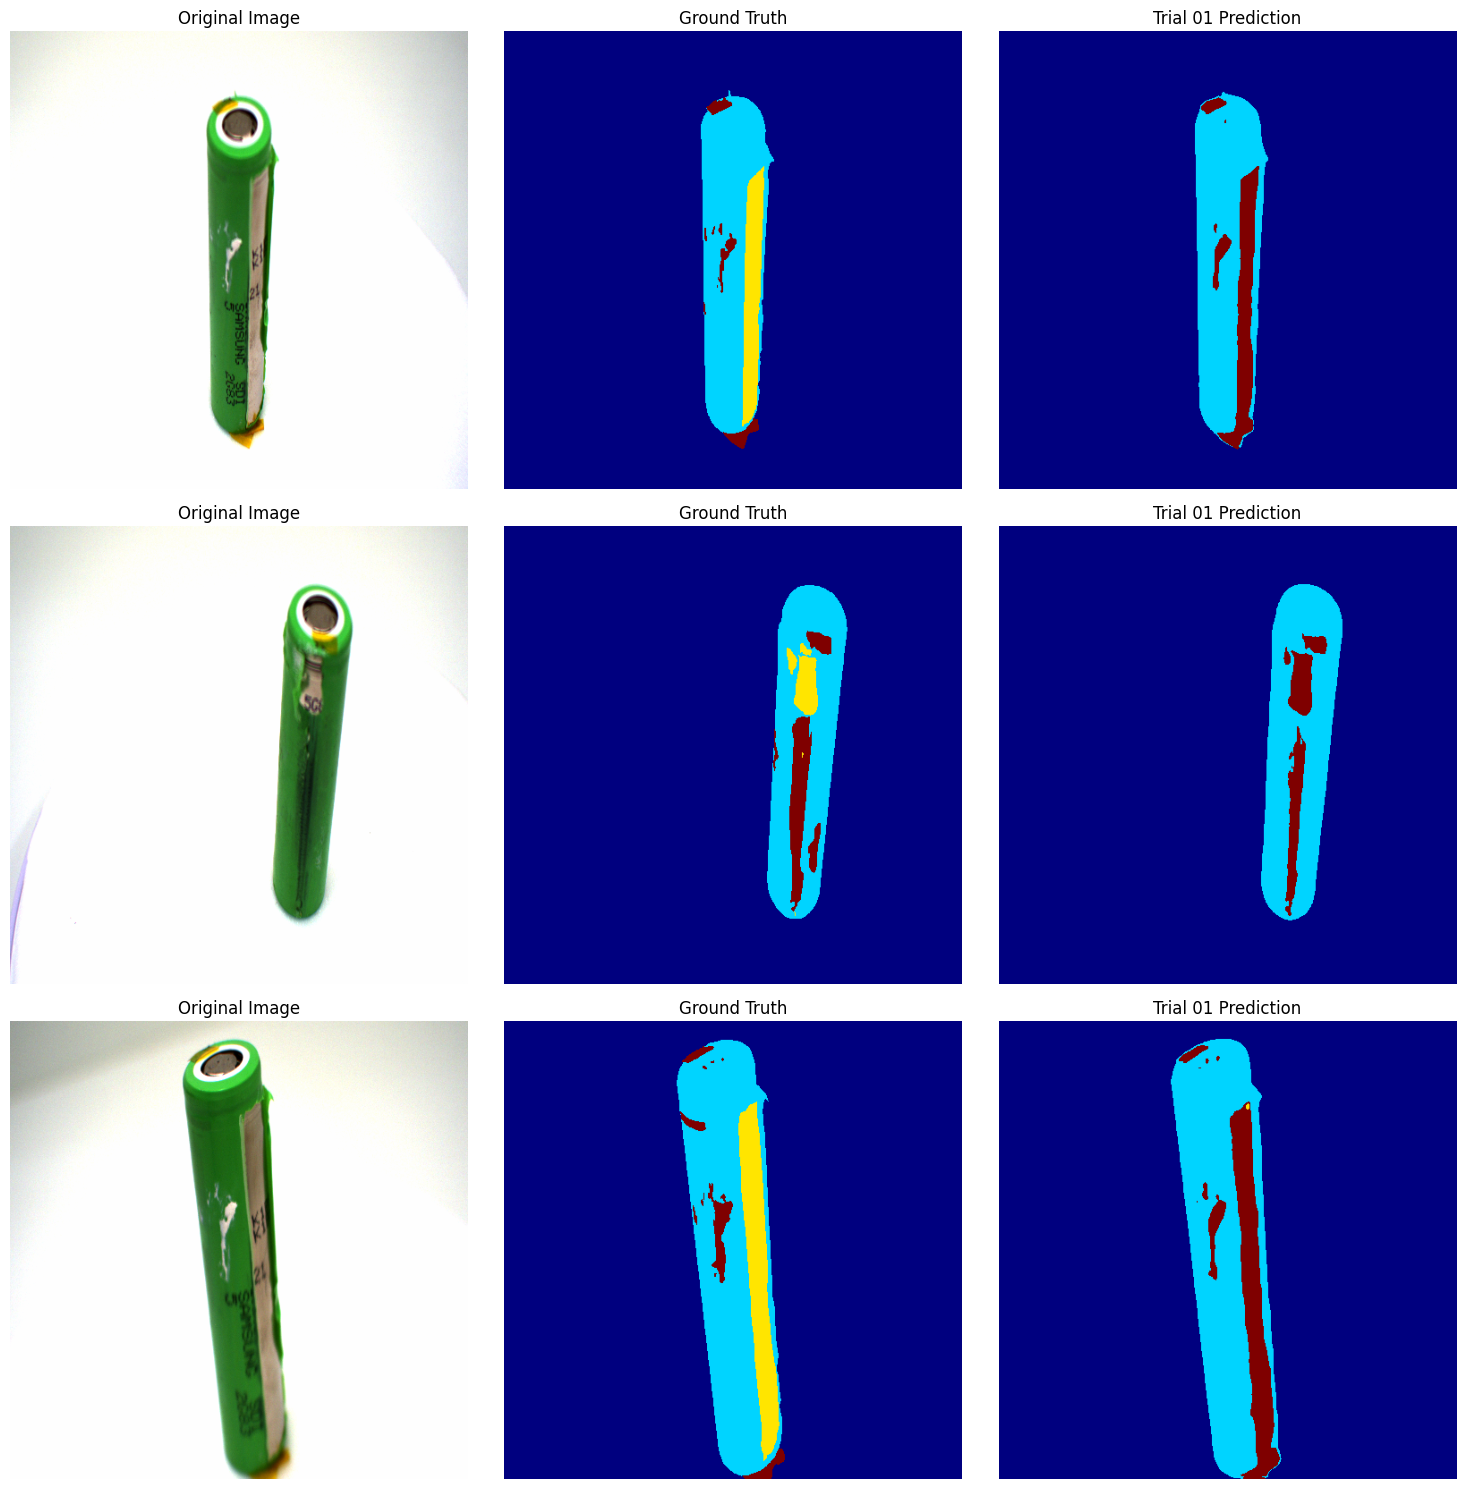

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def test_inference(model, dataloader, device, n_samples=3):
    model.eval()
    # 데이터로더에서 한 배치 가져오기
    batch = next(iter(dataloader))
    images = batch['image'].to(device)
    masks = batch['mask'].to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

    images = images.cpu().numpy()
    masks = masks.cpu().numpy()

    plt.figure(figsize=(15, n_samples * 5))

    for i in range(n_samples):
        # 이미지 복원 (Normalization 해제)
        img = np.transpose(images[i], (1, 2, 0))
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        # 시각화 (원본 | 정답 | 모델 예측)
        display_list = [img, masks[i], preds[i]]
        title = ['Original Image', 'Ground Truth', 'Trial 01 Prediction']

        for j in range(3):
            plt.subplot(n_samples, 3, i*3 + j + 1)
            plt.title(title[j])
            if j == 0:
                plt.imshow(display_list[j])
            else:
                # jet 컬러맵을 사용하여 클래스 구분 (0:배경, 1:본체, 2:파손, 3:오염)
                plt.imshow(display_list[j], cmap='jet', vmin=0, vmax=3)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# 테스트 실행 (val 데이터로더 사용)
test_inference(model, dataloaders['val'], device)

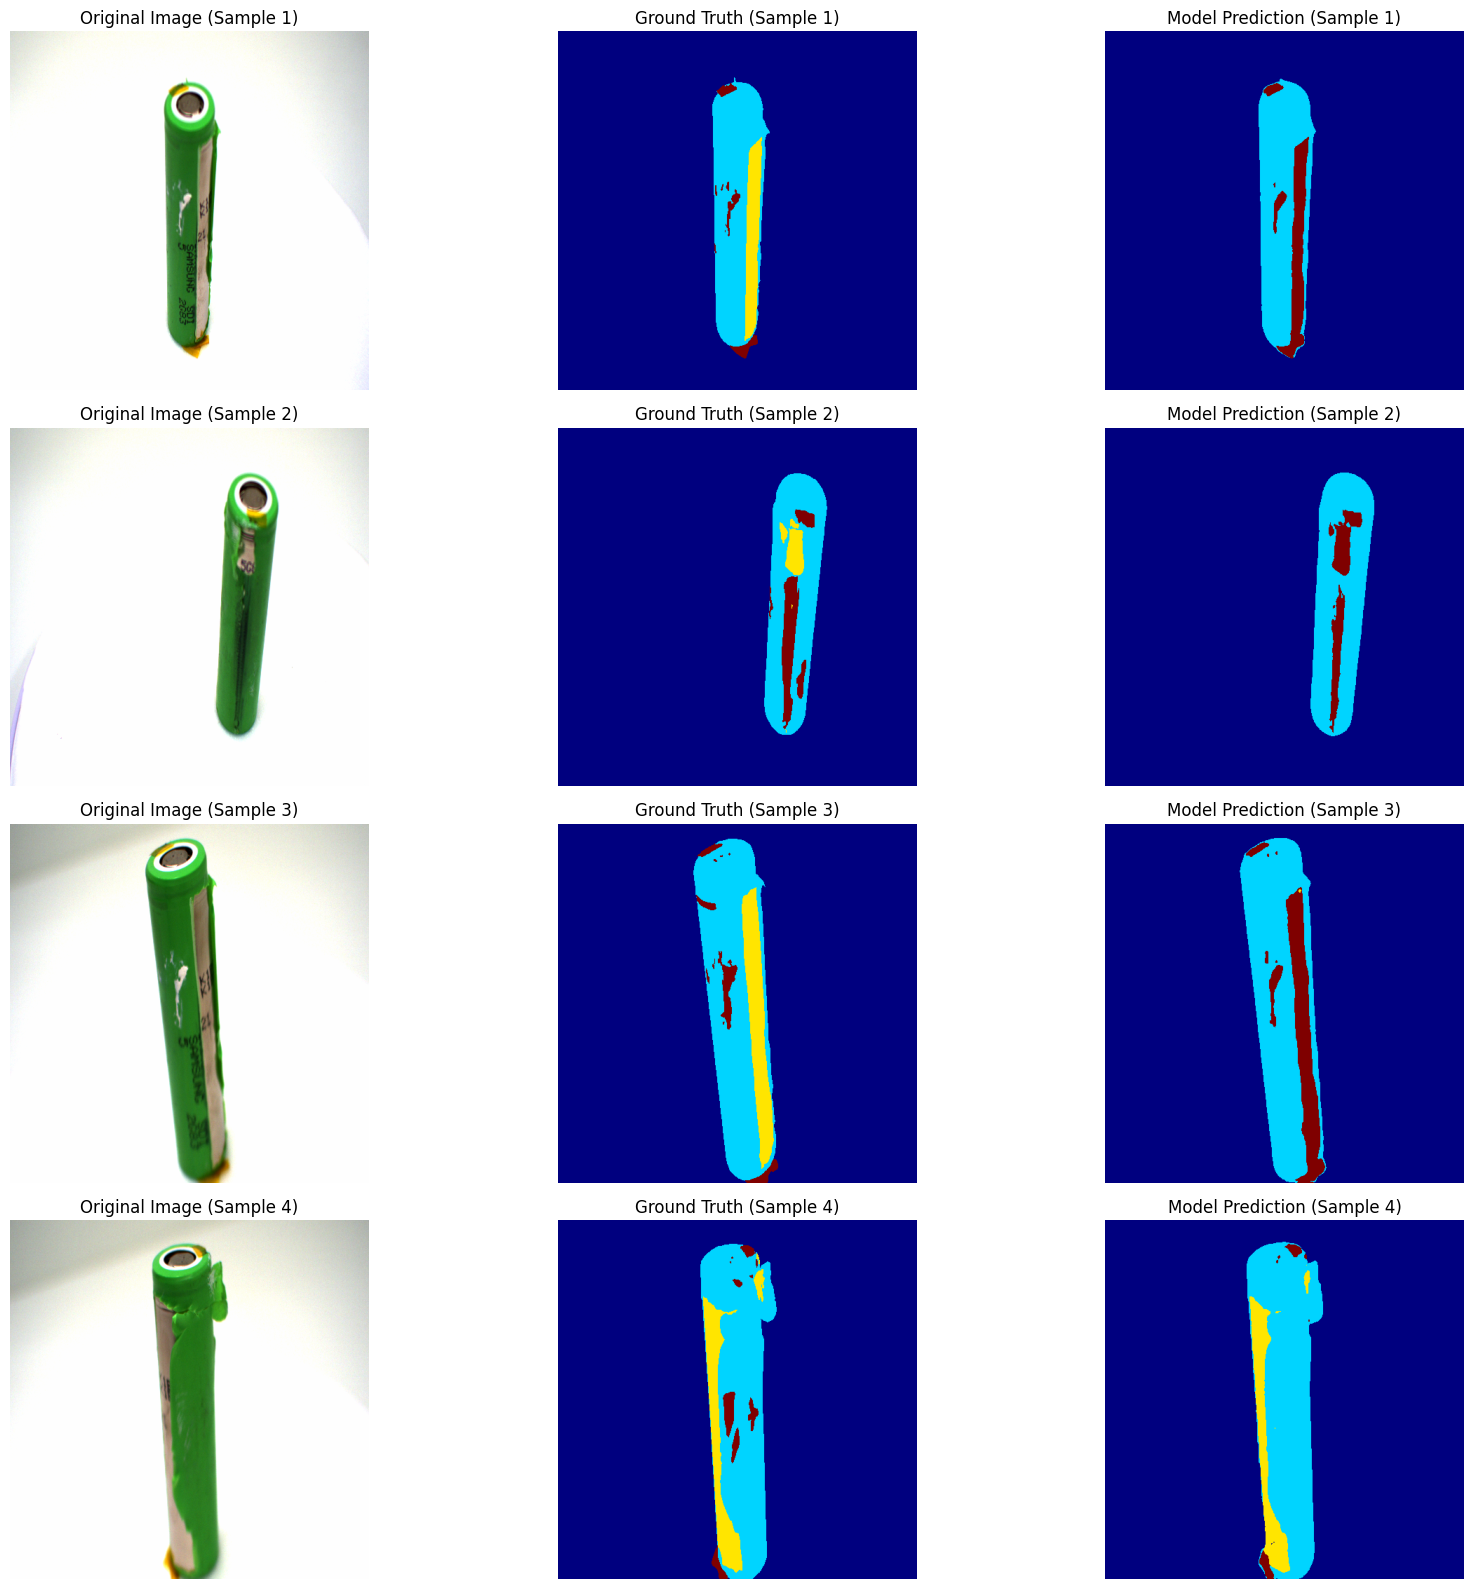

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_final_results(model, dataloader, device, n_samples=4):
    model.eval()
    batch = next(iter(dataloader))
    imgs = batch['image'].to(device)
    masks = batch['mask'].to(device)

    with torch.no_grad():
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

    imgs = imgs.cpu().numpy()
    masks = masks.cpu().numpy()

    plt.figure(figsize=(18, n_samples * 4))

    for i in range(n_samples):
        # 1. 원본 이미지 (Normalize 복원)
        img = np.transpose(imgs[i], (1, 2, 0))
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        # 시각화 배열: [원본, 정답, 예측]
        titles = ['Original Image', 'Ground Truth', 'Model Prediction']
        data = [img, masks[i], preds[i]]

        for j in range(3):
            plt.subplot(n_samples, 3, i * 3 + j + 1)
            if j == 0:
                plt.imshow(data[j])
            else:
                plt.imshow(data[j], cmap='jet', vmin=0, vmax=3)
            plt.title(f"{titles[j]} (Sample {i+1})")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# 실행
visualize_final_results(model, dataloaders['val'], device)

In [ ]:
import wandb
import matplotlib.pyplot as plt

api = wandb.Api()

# 괄호 안에 본인의 [사용자ID/프로젝트명/런ID]를 직접 입력하세요.
# 예: "gildong/battery-defect/39p24z8j"
run_path = "kimyeese-sogang-university/battery-defect-segmentation/eqsha796"
run = api.run(run_path)
history = run.history() # 전체 히스토리 가져오기

# 이제 이전과 동일한 plot_training_results(history) 함수를 실행하면 됩니다.

In [ ]:
# 현재 데이터프레임의 모든 컬럼명 출력
print("현재 저장된 컬럼 리스트:")
print(history.columns.tolist())

현재 저장된 컬럼 리스트:
['train/dice', 'train/loss', 'lr', 'epoch', 'visuals', '_step', 'val/dice', '_timestamp', '_runtime', 'val/loss']


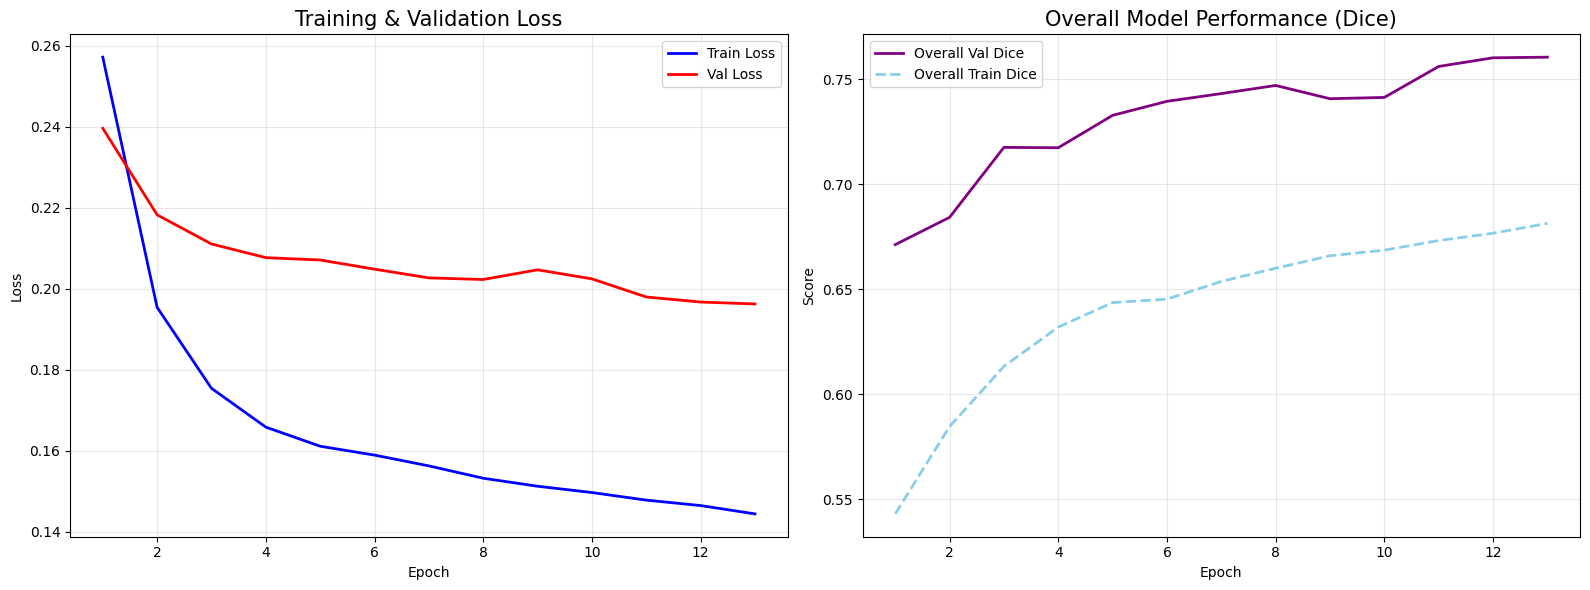

In [ ]:
import matplotlib.pyplot as plt

def plot_available_results(df):
    plt.figure(figsize=(16, 6))

    # 1. Loss 그래프 (정상 출력 가능)
    plt.subplot(1, 2, 1)
    plt.plot(df['epoch'], df['train/loss'], label='Train Loss', color='blue', lw=2)
    plt.plot(df['epoch'], df['val/loss'], label='Val Loss', color='red', lw=2)
    plt.title('Training & Validation Loss', fontsize=15)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. 전체 성능 (Dice Score) 그래프
    plt.subplot(1, 2, 2)
    if 'val/dice' in df.columns:
        plt.plot(df['epoch'], df['val/dice'], label='Overall Val Dice', color='purple', lw=2)
    if 'train/dice' in df.columns:
        plt.plot(df['epoch'], df['train/dice'], label='Overall Train Dice', color='skyblue', lw=2, linestyle='--')

    plt.title('Overall Model Performance (Dice)', fontsize=15)
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_available_results(history)

In [ ]:
from google.colab import drive
import sys
import os

drive.mount('/content/drive')

# 본인의 attention_unet 폴더 경로로 수정하세요
project_path = '/content/drive/MyDrive/attention_unet'
if project_path not in sys.path:
    sys.path.append(project_path)

print(f"✅ 경로 연결 완료: {os.listdir(project_path)}")

In [ ]:
!pip install -q albumentations segmentation-models-pytorch torchsummary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.9 MB/s eta 0:00:00


In [ ]:
import os
import sys
from google.colab import drive

# 1. 드라이브 마운트
drive.mount('/content/drive')

# 2. .py 파일들이 들어있는 폴더 경로 (사용자님의 실제 경로로 수정하세요)
# 아까 이미지에서 본 경로: /content/drive/MyDrive/attention_unet
project_path = '/content/drive/MyDrive/attention_unet'

# 3. 파이썬 경로에 추가
if project_path not in sys.path:
    sys.path.append(project_path)
    print(f"✅ 경로 추가 완료: {project_path}")

# 4. 해당 경로에 파일이 진짜 있는지 확인 (확인용)
print("📂 폴더 내 파일 목록:", os.listdir(project_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 경로 추가 완료: /content/drive/MyDrive/attention_unet
📂 폴더 내 파일 목록: ['README.md', 'att_unet.ipynb', '.ipynb_checkpoints', '__pycache__', 'model.py', 'model_v3.py', 'dataset.py', 'train.py', 'utils.py', 'loss.py', 'visualize.py', 'main.py']


In [ ]:
import torch
import torch.nn as nn
from dataset import SegmentationDataset
from model_v3 import AttentionUNet_MobileNetV3
from utils import get_data_loaders
from train import train_and_test
# from loss import HybridLoss # loss.py에 정의되어 있다면

print("✅ 모든 모듈 임포트 성공!")

✅ 모든 모듈 임포트 성공!


In [ ]:
import importlib
import dataset
importlib.reload(dataset) # 수정된 dataset.py를 강제로 다시 불러옵니다.
from dataset import SegmentationDataset

print("✅ dataset.py의 수정 사항이 반영되었습니다.")

✅ dataset.py의 수정 사항이 반영되었습니다.


In [ ]:
import torch
import numpy as np
import json
import cv2

In [ ]:

# 객체를 새로 생성해야 합니다.
test_ds = SegmentationDataset(subset_path='/content/split_dataset/train', transform=None)
sample = test_ds[0]

mask_unique = np.unique(sample['mask'].numpy())
print(f"📊 최종 마스크 유니크 값: {mask_unique}")

if len(mask_unique) > 1:
    print("🎉 성공! 이제 배경(0) 외에 다른 클래스(1, 2, 3)가 잡힙니다.")
else:
    print("⚠️ 여전히 [0]만 나오나요? 그렇다면 generate_multiclass_mask 내부의 좌표 처리 로직을 더 정밀하게 봐야 합니다.")

NameError: name 'torch' is not defined

In [ ]:
import json
import os

# 1. 실제 존재하는 JSON 파일 경로 하나를 지정하세요 (본인의 경로에 맞게 수정)
# 예: '/content/split_dataset/train/labels/파일이름.json'
json_sample_path = '/content/split_dataset/train/labels/' + os.listdir('/content/split_dataset/train/labels')[0]

print(f"📄 확인 중인 파일: {json_sample_path}")

if os.path.exists(json_sample_path):
    with open(json_sample_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

        # JSON의 첫 번째 수준 키들을 출력
        print(f"🔑 JSON 최상위 키 목록: {list(data.keys())}")

        # 만약 'defects'나 'swelling'이 없다면 다른 이름을 확인해야 합니다.
        if 'defects' in data:
            print("✅ 'defects' 키를 찾았습니다.")
        if 'swelling' in data:
            print("✅ 'swelling' 키를 찾았습니다.")

        # 데이터 샘플 출력 (구조 파악용)
        print("\n📝 데이터 구조 샘플:")
        print(json.dumps(data, indent=2)[:1000]) # 앞부분 500자만 출력
else:
    print("❌ 해당 경로에 JSON 파일이 없습니다! 폴더명을 다시 확인하세요.")

📄 확인 중인 파일: /content/split_dataset/train/labels/RGB_cell_cylindrical_0441_201.json
🔑 JSON 최상위 키 목록: ['data_info', 'swelling', 'defects', 'image_info']
✅ 'defects' 키를 찾았습니다.
✅ 'swelling' 키를 찾았습니다.

📝 데이터 구조 샘플:
{
  "data_info": {
    "data_type": "rgb",
    "battery_ids": 441,
    "application": "\uac00\uc804",
    "type": "cell",
    "form": "cylindrical",
    "date": "2023.09.09",
    "place": "KTR",
    "distance": 17,
    "degree": [
      50,
      15
    ],
    "roi": null
  },
  "swelling": {
    "swelling": false,
    "battery_outline": [
      1105.62,
      120.46,
      1119.37,
      536.77,
      1119.37,
      567.68,
      1123.08,
      602.97,
      1135.49,
      885.32,
      1141.06,
      955.01,
      1139.5,
      974.18,
      1137.57,
      983.62,
      1126.35,
      1006.8,
      1104.73,
      1021.21,
      1058.44,
      1053.53,
      989.26,
      1063.05,
      936.21,
      1053.53,
      909.84,
      1030.65,
      883.46,
      1012.0,
      867.34,

# Streamlit

In [1]:
# Streamlit 및 시각화 도구 설치
!pip install streamlit albumentations pyngrok

# Cloudflare Tunnel 설치 (가장 안정적인 외부 접속 도구)
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!dpkg -i cloudflared-linux-amd64.deb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 114.3 MB/s eta 0:00:00
--2026-01-22 06:17:07--  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cloudflare/cloudflared/releases/download/2026.1.1/cloudflared-linux-amd64.deb [following]
--2026-01-22 06:17:07--  https://github.com/cloudflare/cloudflared/releases/download/2026.1.1/cloudflared-linux-amd64.deb
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/106867604/12aae843-3db0-4414-9b56-e2a442db3e76?sp=r&sv=2018-11-09&sr=b&spr=https&se=2026-01-22T07%3A09%3A00Z&rscd=attachment%3B+f

In [2]:
# model_v3.py

import torch
import torch.nn as nn
import torchvision.models as models

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.up(x)

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, n_coefficients):
        super(AttentionBlock, self).__init__()
        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
    def forward(self, gate, skip_connection):
        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return skip_connection * psi

# 🔥 ASPP 모듈 정의
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, rates=[1, 6, 12, 18]):
        super(ASPP, self).__init__()
        self.stages = nn.ModuleList([
            nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, bias=False),
                          nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True))
        ] + [
            nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, padding=r, dilation=r, bias=False),
                          nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True))
            for r in rates[1:]
        ])
        self.bottleneck = nn.Sequential(
            nn.Conv2d(out_channels * len(rates), out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True)
        )
    def forward(self, x):
        res = torch.cat([stage(x) for stage in self.stages], dim=1)
        return self.bottleneck(res)

class AttentionUNet_MobileNetV3(nn.Module):
    def __init__(self, output_ch=4, pretrained=True):
        super(AttentionUNet_MobileNetV3, self).__init__()
        mobilenet = models.mobilenet_v3_large(weights='DEFAULT' if pretrained else None).features

        self.enc1 = mobilenet[0:2]    # 16 ch
        self.enc2 = mobilenet[2:4]    # 24 ch
        self.enc3 = mobilenet[4:7]    # 40 ch
        self.enc4 = mobilenet[7:13]   # 112 ch
        self.enc5 = mobilenet[13:16]  # 160 ch

        # 🔥 Bottleneck에 ASPP 배치
        self.aspp = ASPP(160, 160)

        self.Up5 = UpConv(160, 112)
        self.Att5 = AttentionBlock(F_g=112, F_l=112, n_coefficients=56)
        self.UpConv5 = ConvBlock(224, 112)

        self.Up4 = UpConv(112, 40)
        self.Att4 = AttentionBlock(F_g=40, F_l=40, n_coefficients=20)
        self.UpConv4 = ConvBlock(80, 40)

        self.Up3 = UpConv(40, 24)
        self.Att3 = AttentionBlock(F_g=24, F_l=24, n_coefficients=12)
        self.UpConv3 = ConvBlock(48, 24)

        self.Up2 = UpConv(24, 16)
        self.Att2 = AttentionBlock(F_g=16, F_l=16, n_coefficients=8)
        self.UpConv2 = ConvBlock(32, 16)

        self.Up_final = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.Conv_1x1 = nn.Conv2d(16, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        e1 = self.enc1(x); e2 = self.enc2(e1); e3 = self.enc3(e2); e4 = self.enc4(e3); e5 = self.enc5(e4)

        # 🔥 ASPP 적용
        e5 = self.aspp(e5)

        d5 = self.Up5(e5)
        s4 = self.Att5(gate=d5, skip_connection=e4)
        d5 = torch.cat((s4, d5), dim=1); d5 = self.UpConv5(d5)

        d4 = self.Up4(d5); s3 = self.Att4(gate=d4, skip_connection=e3)
        d4 = torch.cat((s3, d4), dim=1); d4 = self.UpConv4(d4)

        d3 = self.Up3(d4); s2 = self.Att3(gate=d3, skip_connection=e2)
        d3 = torch.cat((s2, d3), dim=1); d3 = self.UpConv3(d3)

        d2 = self.Up2(d3); s1 = self.Att2(gate=d2, skip_connection=e1)
        d2 = torch.cat((s1, d2), dim=1); d2 = self.UpConv2(d2)

        out = self.Up_final(d2); out = self.Conv_1x1(out)
        return out

In [17]:
!pip install albumentations opencv-python

In [30]:
%%writefile app.py
import sys
import os

# [1] 드라이브 경로 설정 (반드시 import torch 보다 위에 있어야 함)
target_path = "/content/drive/MyDrive/attention_unet_ys"
if target_path not in sys.path:
    sys.path.append(target_path)

import streamlit as st
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# [2] 드라이브에 있는 model_v3.py에서 클래스 불러오기
try:
    from model_v3 import AttentionUNet_MobileNetV3
except ModuleNotFoundError:
    st.error(f"model_v3.py를 찾을 수 없습니다. 경로를 확인하세요: {target_path}")
    st.stop()

# [3] 모델 로드 함수 (캐싱)
@st.cache_resource
def load_model():
    model_path = os.path.join(target_path, "best_model_trial_02.pth")
    model = AttentionUNet_MobileNetV3(output_ch=4)
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()
    return model

# [4] UI 구성
st.set_page_config(page_title="Attention U-Net Demo", layout="wide")
st.title("MobileNetV3 Attention U-Net AI 분석")

# 사이드바에 상태 표시
with st.sidebar:
    st.header("시스템 상태")
    if os.path.exists(os.path.join(target_path, "best_model_trial_02.pth")):
        model = load_model()
        st.success("✅ 모델 및 설계도 로드 완료")
    else:
        st.error("❌ .pth 파일을 찾을 수 없습니다.")

# 메인 분석 화면
uploaded_file = st.file_uploader("이미지를 업로드하세요", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    img = Image.open(uploaded_file).convert('RGB')
    col1, col2 = st.columns(2)

    with col1:
        st.subheader("원본 이미지")
        st.image(img, use_container_width=True)

    if st.button("✨ AI 분석 시작"):
        with st.spinner("분석 중..."):
            # 전처리
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            input_tensor = transform(img).unsqueeze(0)

            # 추론
            with torch.no_grad():
                output = model(input_tensor)
                mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

            # 시각화 (컬러맵 적용)
            colors = np.array([[0,0,0], [255,0,0], [0,255,0], [0,0,255]])
            color_mask = colors[mask].astype(np.uint8)

            with col2:
                st.subheader("분석 결과")
                st.image(color_mask, use_container_width=True)
                st.success("분석 완료!")

Overwriting app.py


In [31]:
import os

# 1. 드라이브 내 모든 폴더를 검색해서 model_v3.py의 경로를 찾습니다.
for root, dirs, files in os.walk("/content/drive/MyDrive"):
    if "model_v3.py" in files:
        print(f"찾았습니다! 실제 폴더 경로: {root}")

찾았습니다! 실제 폴더 경로: /content/drive/MyDrive/attention_unet_ys


In [32]:
import os
path = "/content/drive/MyDrive/attention_unet_ys"
print(os.listdir(path))
# 결과에 'model_v3.py'가 정확히 있는지, 아니면 뒤에 '.txt'가 붙어있는지 확인하세요.

['model.py', 'train.py', 'loss.py', 'visualize.py', '.ipynb_checkpoints', '__pycache__', 'best_model_trial_02.pth', 'main.py', 'utils.py', 'dataset.py', 'app.py', 'model_v3.py']


In [33]:
import sys
import os

# 1. 경로 추가
path_to_model = "/content/drive/MyDrive/attention_unet_ys"
if path_to_model not in sys.path:
    sys.path.append(path_to_model)

# 2. 파이썬이 찾는 전체 경로 목록 출력 (확인용)
print("--- 현재 파이썬 경로 목록 ---")
for p in sys.path:
    print(p)

# 3. 해당 폴더가 진짜 존재하는지 다시 확인
print("\n폴더 존재 여부:", os.path.exists(path_to_model))

--- 현재 파이썬 경로 목록 ---
/content/drive/MyDrive/attention_unet_ys
/content
/env/python
/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/usr/local/lib/python3.12/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.12/dist-packages/IPython/extensions
/root/.ipython
/tmp/tmps8m0o04b
아까_복사한_폴더_경로

폴더 존재 여부: True


In [51]:
import importlib.util
import sys
import os

# 1. 파일의 전체 절대 경로 지정
file_path = "/content/model_v3.py"
module_name = "model_v3"

# 2. 강제 로드 로직
if os.path.exists(file_path):
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)

    # 3. 임포트 테스트
    from model_v3 import AttentionUNet_MobileNetV3
    print("🚀 [성공] 드디어 모델 설계도를 강제로 불러왔습니다!")
else:
    print(f"❌ [실패] 해당 경로에 파일이 없습니다: {file_path}")

🚀 [성공] 드디어 모델 설계도를 강제로 불러왔습니다!


In [49]:
import sys
from google.colab import drive

# 1. 드라이브 마운트 확인
drive.mount('/content/drive')

# 2. 경로 추가
path_to_model = "/content"
if path_to_model not in sys.path:
    sys.path.append(path_to_model)

# 3. 임포트 테스트
from model_v3 import AttentionUNet_MobileNetV3
print("성공적으로 불러왔습니다!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
성공적으로 불러왔습니다!


In [53]:
# 1. 꼬여있는 프로세스들 완전히 종료
!pkill streamlit
!pkill lt

# 2. 스트림릿을 백그라운드에서 실행 (출력이 화면을 가리지 않게 함)
!streamlit run app.py --server.fileWatcherType none > /dev/null 2>&1 &

In [48]:
# 1. 파일을 로컬(/content/)로 복사
!cp /content/drive/MyDrive/attention_unet_ys/model_v3.py /content/
!cp /content/drive/MyDrive/attention_unet_ys/best_model_trial_02.pth /content/

# 2. 복사가 잘 되었는지 확인
!ls -l /content/model_v3.py /content/best_model_trial_02.pth

-rw------- 1 root root 14055261 Jan 22 06:50 /content/best_model_trial_02.pth
-rw------- 1 root root     4753 Jan 22 06:50 /content/model_v3.py


In [57]:
%%writefile app.py
import streamlit as st

st.title("✅ 연결 성공!")
st.write("지금 이 화면이 보인다면 연결 자체는 문제가 없습니다.")
st.write("로딩이 길었던 이유는 **모델 파일 로드 과정**에서의 문제일 가능성이 큽니다.")

if st.button("여기를 클릭해보세요"):
    st.balloons()
    st.success("연결이 아주 잘 되어 있습니다!")

Overwriting app.py


In [66]:
%%writefile app.py
import streamlit as st
import torch
import os
import sys
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

# 경로 강제 추가
if "/content" not in sys.path:
    sys.path.append("/content")

st.set_page_config(layout="wide")
st.title("🏥 AI 분석 시스템 (최종 점검)")

# [1] 모델 로드 함수 (캐싱 처리)
@st.cache_resource
def get_model():
    from model_v3 import AttentionUNet_MobileNetV3
    model = AttentionUNet_MobileNetV3(output_ch=4)
    model.load_state_dict(torch.load("/content/best_model_trial_02.pth", map_location="cpu"))
    model.eval()
    return model

# [2] 상태 표시
st.sidebar.info("시스템 체크 중...")
try:
    # 모델을 미리 불러오지 않고, 필요할 때만 불러오도록 설정 가능하지만
    # 일단 여기서 성공했는지 확인만 합니다.
    if os.path.exists("/content/best_model_trial_02.pth"):
        st.sidebar.success("✅ 파일 준비 완료")
    else:
        st.sidebar.error("❌ 파일 없음")
except Exception as e:
    st.sidebar.error(f"에러: {e}")

# [3] 메인 화면
uploaded_file = st.file_uploader("사진을 여기에 올려주세요", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    img = Image.open(uploaded_file).convert('RGB')
    st.image(img, caption="업로드된 이미지", width=300)

    if st.button("✨ 분석 시작 (클릭하세요)"):
        # 버튼을 누른 순간에만 로딩이 돌게 함
        with st.status("AI 분석 진행 중...", expanded=True) as status:
            try:
                status.write("1. 모델을 메모리에 올리는 중...")
                model = get_model()

                status.write("2. 이미지를 변환하는 중...")
                transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
                input_tensor = transform(img).unsqueeze(0)

                status.write("3. AI가 픽셀을 분석하는 중...")
                with torch.no_grad():
                    output = model(input_tensor)
                    mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

                # 결과 시각화
                status.write("4. 결과를 화면에 그리는 중...")
                colors = np.array([[0,0,0], [255,0,0], [0,255,0], [0,0,255]])
                color_mask = colors[mask].astype(np.uint8)

                col1, col2 = st.columns(2)
                with col1:
                    st.image(img, caption="원본", use_container_width=True)
                with col2:
                    st.image(color_mask, caption="분석 결과", use_container_width=True)

                status.update(label="✅ 분석 완료!", state="complete")
                st.balloons()

            except Exception as e:
                st.error(f"분석 중 에러 발생: {e}")

Overwriting app.py


In [67]:
# 1. 기존 프로세스 강제 종료
!pkill streamlit
!pkill lt
!pkill ssh

# 2. 파일이 제대로 있는지 최종 확인 (없으면 여기서 에러가 날 거예요)
import os
if not os.path.exists("/content/model_v3.py") or not os.path.exists("/content/best_model_trial_02.pth"):
    print("❌ 파일이 로컬(/content)에 없습니다! 복사 명령어를 다시 실행하세요.")
else:
    print("✅ 모든 파일이 로컬에 준비되어 있습니다.")

✅ 모든 파일이 로컬에 준비되어 있습니다.


In [69]:
# 1. 모든 프로세스 강제 종료
!pkill streamlit
!pkill lt
!pkill ssh

# 2. 스트림릿 가동 (백그라운드)
!streamlit run app.py --server.fileWatcherType none > /dev/null 2>&1 &

# 3. 터널 주소 새로 따기 (localtunnel 대신 serveo가 더 안정적일 수 있습니다)
!ssh -o "StrictHostKeyChecking=no" -R 80:localhost:8501 serveo.net

Forwarding HTTP traffic from https://c77551a599c4fd7d-34-125-0-245.serveousercontent.com
